# Stock Movement Prediction
Dataset: [S&P 500](https://www.sharecast.com/index/SP_500/prices/download)<br>
Goal: Predict future **close price**

Implement by three methods:
1. Linear Regression
2. SVM
3. Neural Network(LSTM)

In [1]:
from sklearn import linear_model, metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from datetime import datetime
from sklearn.metrics import accuracy_score

### Build training and testing data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
def build_data(df):
    # Not used: Converting 'Date' column into 'year', 'month', 'date', 'day' to gain more information.
    df['Date'] = pd.to_datetime(df['Date'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['date'] = df['Date'].dt.day
    df['day'] = df['Date'].dt.dayofweek
    df = df.drop(['Date'], axis=1)
    rise = [0]
    
    # Create a new column 'Rise' which indicates if the 'Close Price' is up or down than the day before.
    for i, close in enumerate(df['Close Price'][1:]):
        if df['Close Price'][i+1] >= df['Close Price'][i]:
            rise.append(1)
        else:
            rise.append(0)
    df['Rise'] = pd.DataFrame(rise)
    return df
train = build_data(train)
test = build_data(test)
train.head()

,Open Price,Close Price,High Price,Low Price,Volume,year,month,date,day,Rise
0,902.99,931.80,934.73,899.35,4048270080,2009,1,2,4,0
1,929.17,927.45,936.63,919.53,5413910016,2009,1,5,0,0
2,931.17,934.70,943.85,927.28,5392620032,2009,1,6,1,1
3,927.45,906.65,927.45,902.37,4704940032,2009,1,7,2,0
4,905.73,909.73,910.00,896.81,4991549952,2009,1,8,3,1


Rise是要預測的label，所以單獨切出來。<br>

In [4]:
# Create labels
train_y = train['Rise'].values
test_y = test['Rise'].values

## Logistic Regression
利用前PASTDAY天的'Rise'作為特徵，來預測當天收盤價的漲跌。

In [5]:
PASTDAY = 5
train_x = []
test_x = []
train_x_mean = [] # mean of past N days
test_x_mean = []
def past(data, out, out_mean):
    for i in range(data.shape[0] - PASTDAY):
        val = np.asarray(data.loc[i:i+PASTDAY-1]['Rise'])
        out.append(val)
        out_mean.append([np.mean(val)])

past(train, train_x, train_x_mean)
past(test, test_x, test_x_mean)
train_x = np.asarray(train_x)
test_x = np.asarray(test_x)
train_y = train_y[PASTDAY:]
test_y = test_y[PASTDAY:]

In [6]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2259, 5)
(2259,)
(266, 5)
(266,)


In [7]:
# Not used: use linear regression model to predict the close price directly
"""regr = linear_model.LinearRegression()
regr.fit(x_train, train_y)
y_pred = regr.predict(x_test)

rise = [0]
for past, today in zip(test_x['Close Price'][:-1], y_pred[1:]):
    if today - past >= 0:
        rise.append(1)
    else:
        rise.append(0)
rise = np.asarray(rise)
plt.scatter(range(len(rise)), rise, label='Predict')
plt.grid()
plt.legend()
plt.show()
acc_rate = accuracy_score(test_y, rise) * 100
print("Accuracy = %.2f %%" % acc_rate)"""

'regr = linear_model.LinearRegression()\nregr.fit(x_train, train_y)\ny_pred = regr.predict(x_test)\n\nrise = [0]\nfor past, today in zip(test_x[\'Close Price\'][:-1], y_pred[1:]):\n    if today - past >= 0:\n        rise.append(1)\n    else:\n        rise.append(0)\nrise = np.asarray(rise)\nplt.scatter(range(len(rise)), rise, label=\'Predict\')\nplt.grid()\nplt.legend()\nplt.show()\nacc_rate = accuracy_score(test_y, rise) * 100\nprint("Accuracy = %.2f %%" % acc_rate)'

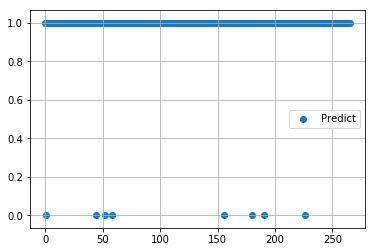

Accuracy = 52.63 %


In [8]:
clf = linear_model.LogisticRegression(solver='lbfgs')
clf.fit(train_x, train_y)
pred_y_regr = clf.predict(test_x)
plt.scatter(range(len(pred_y_regr)), pred_y_regr, label='Predict')
plt.grid()
plt.legend()
plt.show()
acc_rate = accuracy_score(test_y, pred_y_regr) * 100
print("Accuracy = %.2f %%" % acc_rate)

## SVM

In [9]:
from sklearn.svm import SVC

把資料做標準化，可以加快訓練速度

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_x)

train_x_std = scaler.transform(train_x)
test_x_std = scaler.transform(test_x)

/home/shihyu/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shihyu/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shihyu/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [11]:
penalty = 0.05

In [12]:
svm = SVC(C=penalty, kernel="linear", probability=True)
svm.fit(train_x_std, train_y)

SVC(C=0.05, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

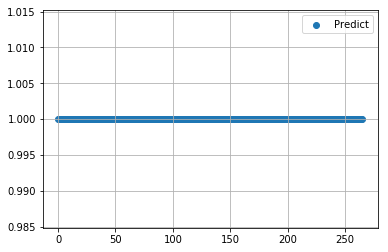

Penalty = 0.05, Accuracy = 52.63 %


In [13]:
pred_y_svm = svm.predict(test_x)
plt.scatter(range(len(pred_y_svm)), pred_y_svm, label='Predict')
plt.grid()
plt.legend()
plt.show()
acc_rate = accuracy_score(test_y, svm.predict(test_x_std)) * 100
print("Penalty = %.2f, Accuracy = %.2f %%" % (penalty, acc_rate))

## Neural Network

In [14]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras import layers

Using TensorFlow backend.


把 label 轉成 onehot-encoding， NN 的輸出層有兩個 output ，一個代表上漲一個代表下跌。

In [15]:
train_y_onehot = np_utils.to_categorical(train_y)
test_y_onehot = np_utils.to_categorical(test_y)

In [16]:
model = Sequential()
model.add(Dense(units=10, input_dim=PASTDAY))
for i in range(5):
    model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dens

In [17]:
model.fit(train_x, train_y_onehot, epochs=10, batch_size=5, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 1807 samples, validate on 452 samples
Epoch 1/10
1807/1807 [==============================] - 3s 2ms/step - loss: 0.6916 - acc: 0.5445 - val_loss: 0.6885 - val_acc: 0.5531
Epoch 2/10
1807/1807 [==============================] - 2s 1ms/step - loss: 0.6882 - acc: 0.5462 - val_loss: 0.6915 - val_acc: 0.5575
Epoch 3/10
1807/1807 [==============================] - 2s 1ms/step - loss: 0.6900 - acc: 0.5462 - val_loss: 0.6891 - val_acc: 0.5531
Epoch 4/10
1807/1807 [==============================] - 2s 1ms/step - loss: 0.6895 - acc: 0.5462 - val_loss: 0.6887 - val_acc: 0.5531
Epoch 5/10
1807/1807 [==============================] - 2s 1ms/step - loss: 0.6879 - acc: 0.5429 - val_loss: 0.6869 - val_acc: 0.5531
Epoch 6/10
1807/1807 [==============================] - 2s 1ms/step - loss: 0.6879 - acc: 0.5462 - val_loss: 0.6854 - val_acc: 0.5531
Epoch 7/10
1807/1807 [==============================] - 2s 1ms/step - loss: 0.6887 - acc: 0.5462 - va

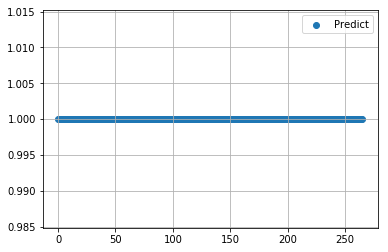

Penalty = 0.05, Accuracy = 52.63 %


In [18]:
pred_y_nn = model.predict_classes(test_x)
plt.scatter(range(len(pred_y_nn)), pred_y_nn, label='Predict')
plt.grid()
plt.legend()
plt.show()
acc_rate = accuracy_score(test_y, pred_y_nn) * 100
print("Penalty = %.2f, Accuracy = %.2f %%" % (penalty, acc_rate))

## Neural Network(LSTM)

LSTM的輸入和輸出都是三維矩陣
- 第一維代表總共有幾筆資料
- 第二維代表有幾個time steps
- 第三維代表每個time steps有幾個attributes

In [19]:
train_x_onehot = np_utils.to_categorical(train_x)
test_x_onehot = np_utils.to_categorical(test_x)
train_y_onehot = train_y_onehot.reshape(2264-PASTDAY, 1, 2)
print(train_x_onehot.shape)
print(train_y_onehot.shape)

(2259, 5, 2)
(2259, 1, 2)


In [20]:
def buildModel(shape):
    model = Sequential()
    model.add(layers.LSTM(10, input_shape=(shape[1], shape[2])))
    model.add(layers.RepeatVector(1))
    model.add(layers.LSTM(10, return_sequences=True))
    model.add(layers.LSTM(10, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(2, activation='softmax')))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    model.summary()
    return model

In [21]:
model = buildModel(train_x_onehot.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                520       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 10)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 10)             840       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 10)             840       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 2)              22        
Total params: 2,222
Trainable params: 2,222
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(train_x_onehot, train_y_onehot, batch_size=128, epochs=10)

Epoch 1/10
2259/2259 [==============================] - 6s 3ms/step - loss: 0.6921 - acc: 0.5476
Epoch 2/10
2259/2259 [==============================] - 1s 230us/step - loss: 0.6900 - acc: 0.5476
Epoch 3/10
2259/2259 [==============================] - 0s 211us/step - loss: 0.6893 - acc: 0.5476
Epoch 4/10
2259/2259 [==============================] - 0s 221us/step - loss: 0.6886 - acc: 0.5476
Epoch 5/10
2259/2259 [==============================] - 0s 219us/step - loss: 0.6885 - acc: 0.5476
Epoch 6/10
2259/2259 [==============================] - 0s 212us/step - loss: 0.6885 - acc: 0.5476
Epoch 7/10
2259/2259 [==============================] - 0s 210us/step - loss: 0.6884 - acc: 0.5476
Epoch 8/10
2259/2259 [==============================] - 0s 219us/step - loss: 0.6884 - acc: 0.5476
Epoch 9/10
2259/2259 [==============================] - 0s 221us/step - loss: 0.6884 - acc: 0.5476
Epoch 10/10
2259/2259 [==============================] - 1s 224us/step - loss: 0.6884 - acc: 0.5476


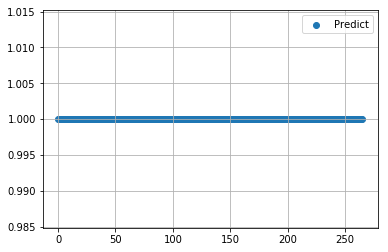

Penalty = 0.05, Accuracy = 52.63 %


In [23]:
pred_y_lstm = model.predict_classes(test_x_onehot)
plt.scatter(range(len(pred_y_lstm)), pred_y_lstm, label='Predict')
plt.grid()
plt.legend()
plt.show()
acc_rate = accuracy_score(test_y, pred_y_lstm) * 100
print("Penalty = %.2f, Accuracy = %.2f %%" % (penalty, acc_rate))

# Conclusion

從上面幾個實驗來看，不管是 Logistic Regression、SVM、Neural Network 的 Dense 或 LSTM ，我做出來的結果幾乎全部都是預測1（上漲）。還找不出較好的方式來改善他們，有猜測或許是我使用的 attribute 只有'Rise'一個，有可能導致模型得到的資料太單薄，因此學不到東西。會再試試加入其他的 attributes 看看模型表現會不會好一點。
<br>另外，我也有嘗試使用 Linear Regression 來直接預測 Close Price ，再轉換成當天漲跌。不過準確率也是在大概五成左右。